In [1]:
import scipy.io as spio

from __future__ import division

import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from matplotlib import ticker
import matplotlib as mpl
from os import path

from scipy.io import loadmat

from wyrm.types import Data

from wyrm import plot
#plot.beautify()
from wyrm.types import Data
from wyrm import processing as proc

DEBUG:matplotlib.backends:backend module://ipykernel.pylab.backend_inline version unknown


In [67]:
import pandas as pd
from sklearn.preprocessing import normalize

In [2]:
TRAIN_A = '../BCI_Comp_III_Wads_2004/data/Subject_A_Train.mat'
TRAIN_B = '../BCI_Comp_III_Wads_2004/data/Subject_B_Train.mat'

TEST_A = '../BCI_Comp_III_Wads_2004/data/Subject_A_Test.mat'
TEST_B = '../BCI_Comp_III_Wads_2004/data/Subject_B_Test.mat'

TRUE_LABELS_A = 'WQXPLZCOMRKO97YFZDEZ1DPI9NNVGRQDJCUVRMEUOOOJD2UFYPOO6J7LDGYEGOA5VHNEHBTXOO1TDOILUEE5BFAEEXAW_K4R3MRU'
TRUE_LABELS_B = 'MERMIROOMUHJPXJOHUVLEORZP3GLOO7AUFDKEFTWEOOALZOP9ROCGZET1Y19EWX65QUYU7NAK_4YCJDVDNGQXODBEV2B5EFDIDNR'

MATRIX = ['abcdef',
          'ghijkl',
          'mnopqr',
          'stuvwx',
          'yz1234',
          '56789_']

MARKER_DEF_TRAIN = {'target': ['target'], 'nontarget': ['nontarget']}
MARKER_DEF_TEST = {'flashing': ['flashing']}

SEG_IVAL = [0, 700]

In [3]:
def load_bci_data(filename):
    """Load the BCI Competition III Data Set 2.
    This method loads the data set and converts it into Wyrm's ``Data``
    format. Before you use it, you have to download the data set in
    Matlab format and unpack it. The directory with the extracted files
    must contain the ``Subject_*.mat``- and the ``eloc64.txt`` files.
    .. note::
        If you need the true labels of the test sets, you'll have to
        download them separately from
        http://bbci.de/competition/iii/results/index.html#labels
    Parameters
    ----------
    filename : str
        The path to the matlab file to load
    Returns
    -------
    cnt : continuous `Data` object
    Examples
    --------
    >>> dat = load_bcicomp3_ds2('/home/foo/data/Subject_A_Train.mat')
    """
    STIMULUS_CODE = {
        0 : "blankMatrix",
        # cols from left to right
        1 : "agmsy5",
        2 : "bhntz6",
        3 : "ciou17",
        4 : "djpv28",
        5 : "ekqw39",
        6 : "flrx4_",
        # rows from top to bottom
        7 : "abcdef",
        8 : "ghijkl",
        9 : "mnopqr",
        10: "stuvwx",
        11: "yz1234",
        12: "56789_"
        }

    # load the matlab data
    data_mat = loadmat(filename)
    # load the channel names (the same for all datasets
    eloc_file = path.sep.join([path.dirname(filename), 'eloc64.txt'])
    with open(eloc_file) as fh:
        data = fh.read()
    channels = []
    for line in data.splitlines():
        if line:
            chan = line.split()[-1]
            chan = chan.replace('.', '')
            channels.append(chan)
    # fix the channel names, some letters have the wrong capitalization
    for i, s in enumerate(channels):
        s2 = s.upper()
        s2 = s2.replace('Z', 'z')
        s2 = s2.replace('FP', 'Fp')
        channels[i] = s2
    # The signal is recorded with 64 channels, bandpass filtered
    # 0.1-60Hz and digitized at 240Hz. The format is Character Epoch x
    # Samples x Channels
    data = data_mat['Signal']
    data = data.astype('double')
    # For each sample: 1 if a row/colum was flashed, 0 otherwise
    flashing = data_mat['Flashing'].reshape(-1)
    #flashing = np.flatnonzero((np.diff(a) == 1)) + 1
    ##Creates an array where only the initial intensifications of each series appear
    tmp = []
    for i, _ in enumerate(flashing):
        if i == 0:
            tmp.append(flashing[i])
            continue
        if flashing[i] == flashing[i-1] == 1:
            tmp.append(0)
            continue
        tmp.append(flashing[i])
    flashing = np.array(tmp)
    # For each sample: 0 when no row/colum was intensified,
    # 1..6 for intensified columns, 7..12 for intensified rows
    stimulus_code = data_mat['StimulusCode'].reshape(-1)
    stimulus_code = stimulus_code[flashing == 1]
    # 0 if no row/col was intensified or the intensified did not contain
    # the target character, 1 otherwise
    stimulus_type = data_mat.get('StimulusType', np.array([])).reshape(-1)
    # The target characters
    target_chars = data_mat.get('TargetChar', np.array([])).reshape(-1)
    fs = 240
    data = data.reshape(-1, 64)
    timeaxis = np.linspace(0, data.shape[0] / fs * 1000, data.shape[0], endpoint=False)
    dat = Data(data=data, axes=[timeaxis, channels], names=['time', 'channel'], units=['ms', '#'])
    dat.fs = fs
    # preparing the markers
    target_mask = np.logical_and((flashing == 1), (stimulus_type == 1)) if len(stimulus_type) > 0 else []
    nontarget_mask = np.logical_and((flashing == 1), (stimulus_type == 0)) if len(stimulus_type) > 0 else []
    flashing = (flashing == 1)
    flashing = [[i, 'flashing'] for i in timeaxis[flashing]]
    targets = [[i, 'target'] for i in timeaxis[target_mask]]
    nontargets = [[i, 'nontarget'] for i in timeaxis[nontarget_mask]]
    dat.stimulus_code = stimulus_code[:]
    stim = []
    for i,_ in enumerate(flashing):
        stim.append([flashing[i][0], STIMULUS_CODE[stimulus_code[i]]])
    stimulus_code = stim
    #stimulus_code = zip([t for t, _ in flashing], [STIMULUS_CODE[i] for i in stimulus_code])
    #Raises error "TypeError: '<' not supported between instances of 'tuple' and 'list'" when calling sort() 
    #stimulus_code =[[t for t,_ in flashing], [STIMULUS_CODE[i] for i in stimulus_code]]
    #print(type(stimulus_code), type(flashing), type(targets), type(nontargets))
    markers = flashing[:]
    markers.extend(targets)
    markers.extend(nontargets)
    markers.extend(stimulus_code)
    markers.sort()
    dat.markers = markers[:]
    return dat


In [4]:
def preprocessing_simple(dat, MRK_DEF, *args, **kwargs):
    """Simple preprocessing that reaches 97% accuracy.
    """
    fs_n = dat.fs / 2
    b, a = proc.signal.butter(5, [10 / fs_n], btype='low')
    dat = proc.filtfilt(dat, b, a)
   
    dat = proc.subsample(dat, 20)
    epo = proc.segment_dat(dat, MRK_DEF, SEG_IVAL)
    fv = proc.create_feature_vectors(epo)
    return fv, epo

In [5]:
dat_train = load_bci_data(TRAIN_A)
dat_test = load_bci_data(TEST_A)

In [6]:
fv_train, epo_train = preprocessing_simple(dat_train, MARKER_DEF_TRAIN, SEG_IVAL)
fv_test, _ = preprocessing_simple(dat_test, MARKER_DEF_TEST, SEG_IVAL)

In [192]:
def predict_character(pred, n_characters, labels, verbose = True):
    pred_target = pred
    #unscramble_idx = fv_test.stimulus_code.reshape(100, 15, 12).argsort()
    unscramble_idx = fv_test.stimulus_code.reshape(n_characters, -1, 12).argsort()
    static_idx = np.indices(unscramble_idx.shape)
    #lda_out_prob = pred.reshape(100, 15, 12)
    lda_out_prob = pred.reshape(n_characters, -1, 12)
    lda_out_prob = lda_out_prob[static_idx[0], static_idx[1], unscramble_idx]

    # destil the result of the 15 runs
    lda_out_prob = lda_out_prob.sum(axis=1)
    lda_out_prob = lda_out_prob.argsort()


    cols = lda_out_prob[lda_out_prob <= 5].reshape(n_characters, -1)
    rows = lda_out_prob[lda_out_prob > 5].reshape(n_characters, -1)
    text = ''
    for i in range(n_characters):
        row = rows[i][-1]-6
        col = cols[i][-1]
        letter = MATRIX[row][col]
        text += letter
    a = np.array(list(text.upper()))
    b = np.array(list(labels))
    accuracy = np.count_nonzero(a == b) / len(a)
    if verbose:
        print()
        print('Constructed labels: %s' % text.upper())
        print('True labels       : %s' % labels)
        print('Accuracy: %.1f%%' % (accuracy * 100))
    return accuracy

In [8]:
from sklearn.neural_network import MLPClassifier

#### Rectified linear unit function

In [55]:
x = fv_train.data
y = fv_train.axes[0]
x_test = fv_test.data

In [23]:
clf = MLPClassifier(hidden_layer_sizes=(100, ), activation='relu', solver='adam')
clf.fit(x, y)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [19]:
pred = clf.predict_proba(x_test)
predict_character(pred[:,1], 100, TRUE_LABELS_A)


Constructed labels: WEX8LZCUMRWC97YFNDEZ1DQI9NN2GX8DJCO2RMEUO1OJTPUFYPOOHJ7LDAYKGOA5VHNEBBTXOO3TEOILUEE5MFGCEXAX7KFR3MRU
True labels       : WQXPLZCOMRKO97YFZDEZ1DPI9NNVGRQDJCUVRMEUOOOJD2UFYPOO6J7LDGYEGOA5VHNEHBTXOO1TDOILUEE5BFAEEXAW_K4R3MRU
Accuracy: 73.0%


#### Sigma function

In [26]:
clf = MLPClassifier(hidden_layer_sizes=(100, ), activation='logistic', solver='adam')
clf.fit(x, y)
pred = clf.predict_proba(x_test)

In [27]:
predict_character(pred[:,1], 100, TRUE_LABELS_A)


Constructed labels: WQWPLZCIMRWOE7YFZDEZ1DPI9NNVGR9DJCOVRMEUOOOJBPUFYPOO6J7LDGYEGOG5VHNEGBUCOO1TDOILUEE5BFAEAXAEOK9RYMRU
True labels       : WQXPLZCOMRKO97YFZDEZ1DPI9NNVGRQDJCUVRMEUOOOJD2UFYPOO6J7LDGYEGOA5VHNEHBTXOO1TDOILUEE5BFAEEXAW_K4R3MRU
Accuracy: 83.0%


#### Hyperbolic tan function

In [28]:
clf = MLPClassifier(hidden_layer_sizes=(100, ), activation='tanh', solver='adam')
clf.fit(x, y)
pred = clf.predict_proba(x_test)

In [29]:
predict_character(pred[:,1], 100, TRUE_LABELS_A)


Constructed labels: WK_PLZCIM4WOK7YFMDEZ1DP79NRVGR9DICUJRMEUOUOJGPUFYPOOH87LDG3EGOG52ZNEUBS_OO1TDOILUEE5BFAEDXMWRKFR3MRU
True labels       : WQXPLZCOMRKO97YFZDEZ1DPI9NNVGRQDJCUVRMEUOOOJD2UFYPOO6J7LDGYEGOA5VHNEHBTXOO1TDOILUEE5BFAEEXAW_K4R3MRU
Accuracy: 72.0%


#### Identity function

In [36]:
from sklearn.preprocessing import normalize

In [42]:
clf = MLPClassifier(hidden_layer_sizes=(100, ), activation='identity', solver='adam')
import time
t_start = time.clock()
clf.fit(normalize(x, axis = 1), y)
t_end = time.clock()
pred = clf.predict_proba(normalize(x_test, axis = 1))

print('time: {} seconds'.format(t_end - t_start))

time: 23.970288614646282 seconds


In [43]:
predict_character(pred[:,1], 100, TRUE_LABELS_A)


Constructed labels: WQXPLZCIMRWO97YFZDEZ1DPI9NNVGRQDJCUVRMEUOOOJD2UFYPOO6J7LDAYEGOA5VHNEHBTXOO1TDOILUEE5HFAEEXAW_K4R3MRU
True labels       : WQXPLZCOMRKO97YFZDEZ1DPI9NNVGRQDJCUVRMEUOOOJD2UFYPOO6J7LDGYEGOA5VHNEHBTXOO1TDOILUEE5BFAEEXAW_K4R3MRU
Accuracy: 96.0%


In [57]:
list_fcns = ['identity', 'tanh', 'logistic', 'relu']

In [72]:
pred, models = MLP_test(x, y, x_test, list_fcns)


Constructed labels: WQWPLZCCM_WO97YFZDDZ1DPI9NNVGR9DJCUVRMEUO1OJD8UFYPOO6H7LDGYEGOA5VTNEHBTXOO1TDOILUEE5AFAFEXATOK4R9MRU
True labels       : WQXPLZCOMRKO97YFZDEZ1DPI9NNVGRQDJCUVRMEUOOOJD2UFYPOO6J7LDGYEGOA5VHNEHBTXOO1TDOILUEE5BFAEEXAW_K4R3MRU
Accuracy: 85.0%
trained identity in 7.16 s

Constructed labels: WQ_PLNCOMRWO_7YFYDEZ1DPJ9NHVGQJDJUOVLMEUOOOJA4UFYPOO6H7LDAYEGOG5VHNE_BJXOOZTDOILUED5AFAFAXAW_K4R3MRU
True labels       : WQXPLZCOMRKO97YFZDEZ1DPI9NNVGRQDJCUVRMEUOOOJD2UFYPOO6J7LDGYEGOA5VHNEHBTXOO1TDOILUEE5BFAEEXAW_K4R3MRU
Accuracy: 76.0%
trained tanh in 17.44 s

Constructed labels: WPXPLNCIMRWO97YFZDEZ1DPR9MNVGR8DJUUV_MEUO7CJD2UFYPOO6H7RDGYEGOA5VTNEEDUXOO1TDOILUEEABFAKEXAWOKER3MRU
True labels       : WQXPLZCOMRKO97YFZDEZ1DPI9NNVGRQDJCUVRMEUOOOJD2UFYPOO6J7LDGYEGOA5VHNEHBTXOO1TDOILUEE5BFAEEXAW_K4R3MRU
Accuracy: 79.0%
trained logistic in 25.89 s

Constructed labels: WQFPLHOIMXEOQ7YFZDEZ1DQL8NQVGRPDHCMV4REUO1OJBPTFYP7OH87X2GYQGOA5V2NEHBUXOOZTDQIKUEE5HASEDXAW_K3X1MRU
True labels       : WQ

In [63]:
import pandas as pd

In [74]:
df = pd.DataFrame(models)
df

,identity,tanh,logistic,relu
accuracy,0.850000,0.760000,0.790000,0.620000
time,7.158911,17.436235,25.894318,10.276268


### Normalized data

In [75]:
x_norm = normalize(x, axis = 1)
x_test_norm = normalize(x_test, axis = 1)
pred, models = MLP_test(x_norm, y, x_test_norm, list_fcns)


Constructed labels: WQXPLZCIMRWO97YFZDEZ1DPI9NNVGRQDJCUVRMEUOOOJD2UFYPOO6J7LDAYEGOA5VHNEHBTXOO1TDOILUEE5NFAEEXAWRK4R3MRU
True labels       : WQXPLZCOMRKO97YFZDEZ1DPI9NNVGRQDJCUVRMEUOOOJD2UFYPOO6J7LDGYEGOA5VHNEHBTXOO1TDOILUEE5BFAEEXAW_K4R3MRU
Accuracy: 95.0%
trained identity in 13.68 s

Constructed labels: WQXPLZCIMRWO97YFZDEZ1DPI9NNVGRQDJCUVRMEUOOOJD2UFYPOO6J7LDAYEGOA5VHNEHBTXOO1TDOILUEE5HFAEEXAW_K4R3MRU
True labels       : WQXPLZCOMRKO97YFZDEZ1DPI9NNVGRQDJCUVRMEUOOOJD2UFYPOO6J7LDGYEGOA5VHNEHBTXOO1TDOILUEE5BFAEEXAW_K4R3MRU
Accuracy: 96.0%
trained tanh in 14.54 s

Constructed labels: WQXPLZCIMRWO97YFZDEZ1DPI9NNVGRQDJCUVRMEUOOOJD2UFYPOO6J7LDAYEGOA5VHNEHBTXOO1TDOILUEE5HFAEEXAW_K4R3MRU
True labels       : WQXPLZCOMRKO97YFZDEZ1DPI9NNVGRQDJCUVRMEUOOOJD2UFYPOO6J7LDGYEGOA5VHNEHBTXOO1TDOILUEE5BFAEEXAW_K4R3MRU
Accuracy: 96.0%
trained logistic in 50.03 s

Constructed labels: WQSPLZCIMRKO97YFZDEZ1DPA9MN2GRQDJUUJRMEUOUOJAPUFYPOO6KOLDGYEGOG5VHNEHBTXOO1TCOILUEEANFAFEXAW7K4R3MXU
True labels       : W

In [76]:
df = pd.DataFrame(models)
df

,identity,tanh,logistic,relu
accuracy,0.950000,0.960000,0.96000,0.810000
time,13.676181,14.544991,50.02758,74.283147


### Hidden layers size

In [84]:
x_norm = normalize(x, axis = 1)
x_test_norm = normalize(x_test, axis = 1)
pred, models = MLP_test(x_norm, y, x_test_norm, list_fcns, (200,))


Constructed labels: WQXPLZCOMRWO97YFZDEZ1DPI9NNVGRPDJCUVRMEUOOOJD2UFYPOO6J7LDAYEGOA5VHNEHBTXOO1TDOILUEE5NFAEEXAW_K4R3MRU
True labels       : WQXPLZCOMRKO97YFZDEZ1DPI9NNVGRQDJCUVRMEUOOOJD2UFYPOO6J7LDGYEGOA5VHNEHBTXOO1TDOILUEE5BFAEEXAW_K4R3MRU
Accuracy: 96.0%
trained identity in 16.45 s

Constructed labels: WQXPLZCIMRWO97YFZDEZ1DPI9NNVGRQDJCUVRMEUOOOJD2UFYPOO6J7LDAYEGOA5VHNEKBTXOO1TDOILUEE5HFAEEXAWRK4R3MRU
True labels       : WQXPLZCOMRKO97YFZDEZ1DPI9NNVGRQDJCUVRMEUOOOJD2UFYPOO6J7LDGYEGOA5VHNEHBTXOO1TDOILUEE5BFAEEXAW_K4R3MRU
Accuracy: 94.0%
trained tanh in 20.22 s

Constructed labels: WQXPLZCIMRWO97YFZDEZ1DPI9NNVGRQDJCUVRMEUOOOJD2UFYPOO6J7LDAYEGOA5VHNEHBTXOO1TDOILUEE5HFAEEXAW_K4R3MRU
True labels       : WQXPLZCOMRKO97YFZDEZ1DPI9NNVGRQDJCUVRMEUOOOJD2UFYPOO6J7LDGYEGOA5VHNEHBTXOO1TDOILUEE5BFAEEXAW_K4R3MRU
Accuracy: 96.0%
trained logistic in 52.40 s

Constructed labels: WWXPLZFIMREO97YFZDEZ1DPC9NN2GRQDJUOJ4MEUOUOJDPUFYPOO6K7LDAYEGOA5VHNEZBTXO1ZBDOILUEEAHF5FEXAWUK4R3MXU
True labels       : W

In [85]:
df = pd.DataFrame(models)
df

,identity,tanh,logistic,relu
accuracy,0.960000,0.940000,0.960000,0.76000
time,16.448045,20.220809,52.403316,92.07403


In [86]:
x_norm = normalize(x, axis = 1)
x_test_norm = normalize(x_test, axis = 1)
pred, models = MLP_test(x_norm, y, x_test_norm, list_fcns, (50,))


Constructed labels: WQXPLZCIMRWO97YFZDEZ1DPI9NNVGRQDJCUVRMEUOOOJD2UFYPOO6J7LDAYEGOA5VTNEHBTXOO1TDOILUEE5HFAEEXAW_K4R3MRU
True labels       : WQXPLZCOMRKO97YFZDEZ1DPI9NNVGRQDJCUVRMEUOOOJD2UFYPOO6J7LDGYEGOA5VHNEHBTXOO1TDOILUEE5BFAEEXAW_K4R3MRU
Accuracy: 95.0%
trained identity in 9.45 s

Constructed labels: WQXPLZCIMRWO97YFZDEZ1DPI9NNVGRPDJCUVRMEUOOOJD2UFYPOO6J7LDAYEGOA5VTNEHBTXOO1TDOILUEE5BFAEEXAW_K4R3MRU
True labels       : WQXPLZCOMRKO97YFZDEZ1DPI9NNVGRQDJCUVRMEUOOOJD2UFYPOO6J7LDGYEGOA5VHNEHBTXOO1TDOILUEE5BFAEEXAW_K4R3MRU
Accuracy: 95.0%
trained tanh in 21.66 s

Constructed labels: WQXPLZCIMRWO97YFZDEZ1DPI9NNVGRQDJCUVRMEUOOOJD2UFYPOO6J7LDAYEGOA5VHNEHBTXOO1TDOILUEE5NFAEEXAW_K4R3MRU
True labels       : WQXPLZCOMRKO97YFZDEZ1DPI9NNVGRQDJCUVRMEUOOOJD2UFYPOO6J7LDGYEGOA5VHNEHBTXOO1TDOILUEE5BFAEEXAW_K4R3MRU
Accuracy: 96.0%
trained logistic in 51.22 s

Constructed labels: WQXPLZCIM4ECW7YIZDEZ1DQL9NNVGR8DJUIVRMEUOUOJA2UFYPOO687LDGYEGOA5VHNEHATXOO1TDOILUEE5BFAFEXAE_KFR3MXU
True labels       : WQ

In [87]:
df = pd.DataFrame(models)
df

,identity,tanh,logistic,relu
accuracy,0.950000,0.950000,0.960000,0.810000
time,9.451202,21.663958,51.218713,64.421723


In [68]:
x_norm = normalize(x, axis = 1)
x_test_norm = normalize(x_test, axis = 1)

In [88]:
pred, models = MLP_test(x_norm, y, x_test_norm, list_fcns, (20,))


Constructed labels: WQXPLZCOMRWO97YFZDEZ1DPI9NNVGRQDJCUVRMEUOOOJD2UFYPOO6J7LDAYEGOA5VHNEHBTXOO1TDOILUEE5NFAEEXAW_K4R3MRU
True labels       : WQXPLZCOMRKO97YFZDEZ1DPI9NNVGRQDJCUVRMEUOOOJD2UFYPOO6J7LDGYEGOA5VHNEHBTXOO1TDOILUEE5BFAEEXAW_K4R3MRU
Accuracy: 97.0%
trained identity in 15.43 s

Constructed labels: WQXPLZCIMRWO97YFZDEZ1DPI9NNVGRQDJCUVRMEUOOOJD2UFYPOO6J7LDAYEGOA5VTNEHBTXOO1TDOILUEE5NFAEEXAW_K4R3MRU
True labels       : WQXPLZCOMRKO97YFZDEZ1DPI9NNVGRQDJCUVRMEUOOOJD2UFYPOO6J7LDGYEGOA5VHNEHBTXOO1TDOILUEE5BFAEEXAW_K4R3MRU
Accuracy: 95.0%
trained tanh in 15.06 s

Constructed labels: WQXPLZCIMRWO97YFZDEZ1DPI9NNVGRQDJCUVRMEUOOOJD2UFYPOO6J7LDAYEGOA5VHNEHBTXOO1TDOILUEE5HFAEEXAW_K4R3MRU
True labels       : WQXPLZCOMRKO97YFZDEZ1DPI9NNVGRQDJCUVRMEUOOOJD2UFYPOO6J7LDGYEGOA5VHNEHBTXOO1TDOILUEE5BFAEEXAW_K4R3MRU
Accuracy: 96.0%
trained logistic in 34.34 s

Constructed labels: WQXPLZELMREO57YFYDEZ1DPL9NNVGR8DHUUVRMEUOOOJJPUFYPOO6J7LDAYE5OA5VHBE6BTXOO1TDOILUEEAMFAEEXAW_K4R3MXU
True labels       : W

In [89]:
x_norm = normalize(x, axis = 1)
x_test_norm = normalize(x_test, axis = 1)
pred, models = MLP_test(x_norm, y, x_test_norm, list_fcns, (10,))


Constructed labels: WQXPLZCIMRWO97YFZDEZ1DPI9NNVGRQDJCUVRMEUOOOJD2UFYPOO6J7LDAYEGOA5VHNEHBTXOO1TDOILUEE5BFAEEXAW_K4R3MRU
True labels       : WQXPLZCOMRKO97YFZDEZ1DPI9NNVGRQDJCUVRMEUOOOJD2UFYPOO6J7LDGYEGOA5VHNEHBTXOO1TDOILUEE5BFAEEXAW_K4R3MRU
Accuracy: 97.0%
trained identity in 19.51 s

Constructed labels: WQXPLZCIMRWO97YFZDEZ1DPI9NNVGRQDJCUVRMEUOOOJD2UFYPOO6J7LDAYEGOA5VHNEHBTXOO1TDOILUEE5HFAEEXAW_K4R3MRU
True labels       : WQXPLZCOMRKO97YFZDEZ1DPI9NNVGRQDJCUVRMEUOOOJD2UFYPOO6J7LDGYEGOA5VHNEHBTXOO1TDOILUEE5BFAEEXAW_K4R3MRU
Accuracy: 96.0%
trained tanh in 16.00 s

Constructed labels: WQXPLZCIMRWO97YFZDEZ1DPI9NNVGRQDJCUVRMEUOOOJD2UFYPOO6J7LDAYEGOA5VHNEHBTXOO1TDOILUEE5HFAEEXAW_K4R3MRU
True labels       : WQXPLZCOMRKO97YFZDEZ1DPI9NNVGRQDJCUVRMEUOOOJD2UFYPOO6J7LDGYEGOA5VHNEHBTXOO1TDOILUEE5BFAEEXAW_K4R3MRU
Accuracy: 96.0%
trained logistic in 43.60 s

Constructed labels: WPYPLZDOMREO97YFZ2EZ1DPC9NN2GRPDHUIV_MEUOCOJDPUFYPOO9J7RDGYEGOG5VLNEHBTXOO1TEOHLUEEABF5FEXAW_K4R3MRU
True labels       : W

In [90]:
df = pd.DataFrame(models)
df

,identity,tanh,logistic,relu
accuracy,0.970000,0.960000,0.960000,0.770000
time,19.509023,16.000125,43.601013,86.100817


In [91]:
x_norm = normalize(x, axis = 1)
x_test_norm = normalize(x_test, axis = 1)
pred, models = MLP_test(x_norm, y, x_test_norm, list_fcns, (5,))


Constructed labels: WQXPLZCIMRWO97YFZDEZ1DPI9NNVGRQDJCUVRMEUOOOJD2UFYPOO6J7LDAYEGOA5VTNEHBTXOO1TDOILUEE5NFAEEXAWRK4R3MRU
True labels       : WQXPLZCOMRKO97YFZDEZ1DPI9NNVGRQDJCUVRMEUOOOJD2UFYPOO6J7LDGYEGOA5VHNEHBTXOO1TDOILUEE5BFAEEXAW_K4R3MRU
Accuracy: 94.0%
trained identity in 12.43 s

Constructed labels: WQXPLZCIMRWO97YFZDEZ1DPI9NNVGRPDJCUVRMEUOOOJD2UFYPOO6J7LDAYEGOA5VHNEHBTXOO1TDOILUEE5NFAEEXAW_K4R3MRU
True labels       : WQXPLZCOMRKO97YFZDEZ1DPI9NNVGRQDJCUVRMEUOOOJD2UFYPOO6J7LDGYEGOA5VHNEHBTXOO1TDOILUEE5BFAEEXAW_K4R3MRU
Accuracy: 95.0%
trained tanh in 17.66 s

Constructed labels: WQXPLZCIMRWO97YFZDEZ1DPI9NNVGRQDJCUVRMEUOOOJD2UFYPOO6J7LDAYEGOA5VHNEHBTXOO1TDOILUEE5HFAEEXAW_K4R3MRU
True labels       : WQXPLZCOMRKO97YFZDEZ1DPI9NNVGRQDJCUVRMEUOOOJD2UFYPOO6J7LDGYEGOA5VHNEHBTXOO1TDOILUEE5BFAEEXAW_K4R3MRU
Accuracy: 96.0%
trained logistic in 37.09 s

Constructed labels: WPXPLZCIM4EO97YDZDEZ1DPC9NNVGR8DJC5VLMEUOUOJDPUFYPOO6J7LDAYEGOA5VHNEBBTXUO1TDOHLUEE5BFAEEXEW7K4R3MRU
True labels       : W

### Tomar una parte del training set para validar

Training set: tomo 70% para entrenar y 30% para validar.

In [228]:
x_train = fv_train.data
y_train = fv_train.axes[0]

In [229]:
import time
def MLP_test(X_train, Y_train, X_test, fcns, hsizes = (100,), verbose = True, valid = False):
    predictions = {}
    models_perf = {}
    for i, fcn in enumerate(fcns):
        classifier = MLPClassifier(activation = fcn, hidden_layer_sizes = hsizes)
        if valid:
            # For validation split training data into
            # 70% training and 30% validation
            nt = round(X_train.shape[0] * 0.7)
            X_valid = X_train[nt:,:]
            X_train = X_train[:nt,:]
            Y_valid = Y_train[nt:]
            Y_train = Y_train[:nt]
            
        t_start = time.clock()
        classifier.fit(X_train, Y_train)
        t_end = time.clock()        
        t_diff = t_end - t_start
        pred = classifier.predict_proba(X_test)
        train_score = classifier.score(X_train, Y_train)
        acc = predict_character(pred[:,1], 100, TRUE_LABELS_A, verbose = verbose)
        if valid:
            val_score = classifier.score(X_valid, Y_valid)
            models_perf[fcn] = {'Time [s]': t_diff, 'Train score': train_score, 
                            'Validation score': val_score, 'Accuracy [%]': acc*100}
        else: 
            models_perf[fcn] = {'Time [s]': t_diff, 'Train score': train_score, 
                                'Accuracy [%]': acc*100}
        if verbose:
            print("trained {fn} in {f:.2f} s".format(fn = fcn,f = t_diff))

    return pred, models_perf

In [230]:
pred, models = MLP_test(x, y, x_test, list_fcns, valid = True)


Constructed labels: W9X8LZOFMREA9OYFZDEZ1CP69NR2GRHDJCOJRMEUOUOJBPTFYP7QNE7RDGYESOH5VUTEBBU_UO1TDOILUEE5NFB9DXAE9K4R3MLU
True labels       : WQXPLZCOMRKO97YFZDEZ1DPI9NNVGRQDJCUVRMEUOOOJD2UFYPOO6J7LDGYEGOA5VHNEHBTXOO1TDOILUEE5BFAEEXAW_K4R3MRU
Accuracy: 62.0%
trained identity in 3.43 s

Constructed labels: WQXVLZC1M4KC_7YLYDEZ1DPC9NQ8HRKDHUXJMMEUCOCJDPUFMP7O6K7LDAYEGOG5VTNEFAVXOO1TDOILUEEANFADAXFWLKYR3MRU
True labels       : WQXPLZCOMRKO97YFZDEZ1DPI9NNVGRQDJCUVRMEUOOOJD2UFYPOO6J7LDGYEGOA5VHNEHBTXOO1TDOILUEE5BFAEEXAW_K4R3MRU
Accuracy: 64.0%
trained tanh in 5.72 s

Constructed labels: WQXVLHCIM_WO97YDBDEZ1DPI9NNVG4QDJCOXRMEVOUCJD2UFYPOO9W7FDAYEGOG5VZNEHBH_OO1TDOILUEE5MF5DEXAWRK3R9MXU
True labels       : WQXPLZCOMRKO97YFZDEZ1DPI9NNVGRQDJCUVRMEUOOOJD2UFYPOO6J7LDGYEGOA5VHNEHBTXOO1TDOILUEE5BFAEEXAW_K4R3MRU
Accuracy: 72.0%
trained logistic in 6.81 s

Constructed labels: WKX7L6L1N_ROW7YFWDEZ1BQH9MN3G4PVJUXHRPETUUOJN2U_YMIOJHIGDGYKGO65VVNEJFUUO13BFOZKUED5BF5_FXATOK4RYQR1
True labels       : WQXP

In [231]:
df = pd.DataFrame(models)
df

,identity,tanh,logistic,relu
Accuracy [%],62.000000,64.000000,72.000000,45.000000
Time [s],3.434876,5.716495,6.814153,1.360296
Train score,0.827544,0.913966,0.969893,0.951279
Validation score,0.797603,0.802365,0.823477,0.774460


In [232]:
pred, models = MLP_test(x_norm, y, x_test_norm, list_fcns,(50,), valid = True)


Constructed labels: WQXPLZCOMRWO97YFZDEZ1DPI9NNVGRQDJCUVRMEUOOOJD2UFYPOO6J7LDGYEGOA5VZNEHBTXOO1TDOILUEE5NFAQEXAW7K4R3MRU
True labels       : WQXPLZCOMRKO97YFZDEZ1DPI9NNVGRQDJCUVRMEUOOOJD2UFYPOO6J7LDGYEGOA5VHNEHBTXOO1TDOILUEE5BFAEEXAW_K4R3MRU
Accuracy: 95.0%
trained identity in 8.66 s

Constructed labels: WQXPLZCIM_KO97YFYDEZ1DPI9NNVGRQDJCUVRMEUOUOJD2UFYPOO6J7LDAYEGOA5VZNEHBTXOO1TDOILUEE5NFAEEXAWOK4R3MXU
True labels       : WQXPLZCOMRKO97YFZDEZ1DPI9NNVGRQDJCUVRMEUOOOJD2UFYPOO6J7LDGYEGOA5VHNEHBTXOO1TDOILUEE5BFAEEXAW_K4R3MRU
Accuracy: 91.0%
trained tanh in 7.18 s


C:\Users\sofis\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)



Constructed labels: WQXPLZCIMRQO97YFZDEZ1DPI9NNVGRQDJCUJRMEUOOOJD2UFYPOO6H7LDGYEGOA5VZNEHBTXOO1TDOILUEE5NFAEEXAWOK4R3MXU
True labels       : WQXPLZCOMRKO97YFZDEZ1DPI9NNVGRQDJCUVRMEUOOOJD2UFYPOO6J7LDGYEGOA5VHNEHBTXOO1TDOILUEE5BFAEEXAW_K4R3MRU
Accuracy: 92.0%
trained logistic in 15.51 s

Constructed labels: WWXPLNCIM_NUS7YFYDEZ1DQ69NN2GRDDJC1HRMEU1UOJD2UFYP7O6H1LDAYEGOB5VZNEFBUIOO1TDOHRUEE5BF54DXAB7K4R3MXU
True labels       : WQXPLZCOMRKO97YFZDEZ1DPI9NNVGRQDJCUVRMEUOOOJD2UFYPOO6J7LDGYEGOA5VHNEHBTXOO1TDOILUEE5BFAEEXAW_K4R3MRU
Accuracy: 67.0%
trained relu in 11.48 s


## Comparación tamaños de capas ocultas

In [233]:
h_sizes = [10, 20, 50, 100, 200, 300]

In [234]:
model = []
for h in h_sizes:
    model.append(MLP_test(x_norm, y, x_test_norm, list_fcns,(h,), valid = True, verbose = False))
    
    

C:\Users\sofis\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [235]:
times_dict = {}
for fcn in list_fcns:
    t = []
    for i in range(len(h_sizes)):
        t.append(model[i][1][fcn]['Time [s]'])
    times_dict[fcn] = t
acc_dict = {}
for fcn in list_fcns:
    a = []
    for i in range(len(h_sizes)):
        a.append(model[i][1][fcn]['Accuracy [%]'])
    acc_dict[fcn] = a

valscore_dict = {}
for fcn in list_fcns:
    a = []
    for i in range(len(h_sizes)):
        a.append(model[i][1][fcn]['Validation score'])
    valscore_dict[fcn] = a

trainscore_dict = {}
for fcn in list_fcns:
    a = []
    for i in range(len(h_sizes)):
        a.append(model[i][1][fcn]['Train score'])
    trainscore_dict[fcn] = a    
        

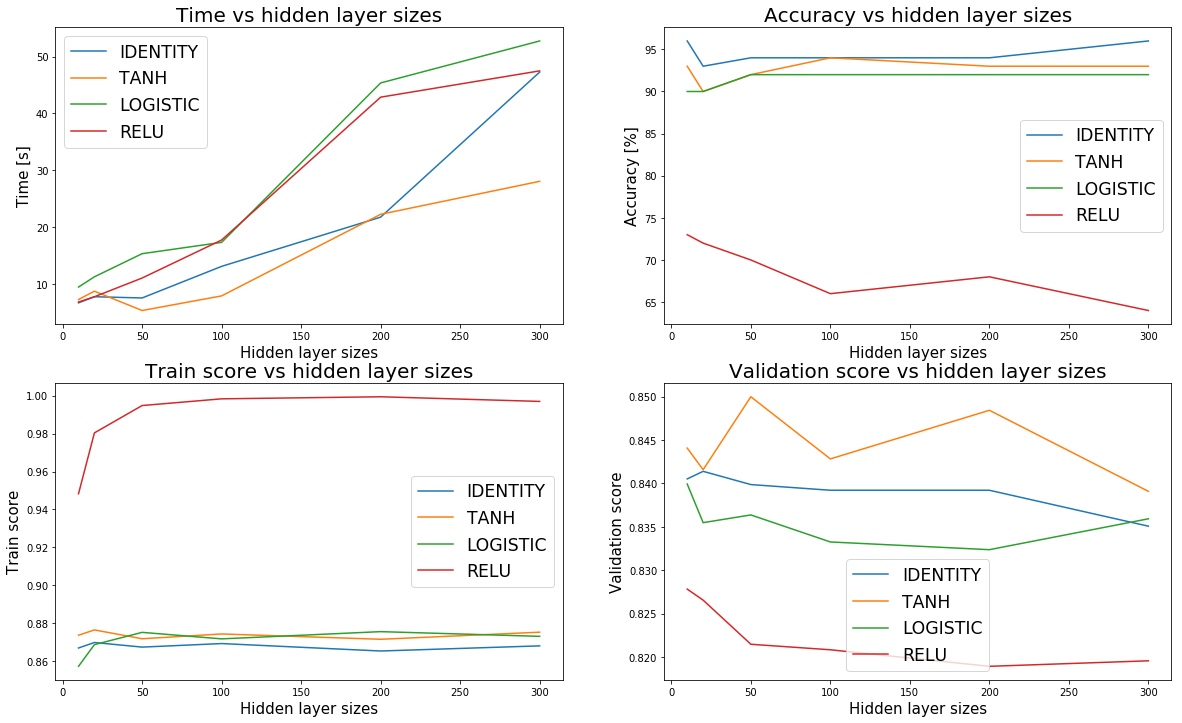

In [236]:
fig = plt.figure(figsize = (20,12))

plt.subplot(221)
plt.plot(h_sizes, times_dict[list_fcns[0]], label = list_fcns[0].upper())
plt.plot(h_sizes, times_dict[list_fcns[1]], label = list_fcns[1].upper())
plt.plot(h_sizes, times_dict[list_fcns[2]], label = list_fcns[2].upper())
plt.plot(h_sizes, times_dict[list_fcns[3]], label = list_fcns[3].upper())
plt.legend(fontsize='xx-large')
plt.xlabel('Hidden layer sizes', fontsize = 15)
plt.ylabel('Time [s]', fontsize = 15)
plt.title('Time vs hidden layer sizes', fontsize = 20)

plt.subplot(222)
plt.plot(h_sizes, acc_dict[list_fcns[0]], label = list_fcns[0].upper())
plt.plot(h_sizes, acc_dict[list_fcns[1]], label = list_fcns[1].upper())
plt.plot(h_sizes, acc_dict[list_fcns[2]], label = list_fcns[2].upper())
plt.plot(h_sizes, acc_dict[list_fcns[3]], label = list_fcns[3].upper())
plt.legend(fontsize='xx-large')
plt.xlabel('Hidden layer sizes', fontsize = 15)
plt.ylabel('Accuracy [%]', fontsize = 15)
plt.title('Accuracy vs hidden layer sizes', fontsize = 20)

plt.subplot(223)
plt.plot(h_sizes, trainscore_dict[list_fcns[0]], label = list_fcns[0].upper())
plt.plot(h_sizes, trainscore_dict[list_fcns[1]], label = list_fcns[1].upper())
plt.plot(h_sizes, trainscore_dict[list_fcns[2]], label = list_fcns[2].upper())
plt.plot(h_sizes, trainscore_dict[list_fcns[3]], label = list_fcns[3].upper())
plt.legend(fontsize='xx-large')
plt.xlabel('Hidden layer sizes', fontsize = 15)
plt.ylabel('Train score', fontsize = 15)
plt.title('Train score vs hidden layer sizes', fontsize = 20)
plt.subplot(224)
plt.plot(h_sizes, valscore_dict[list_fcns[0]], label = list_fcns[0].upper())
plt.plot(h_sizes, valscore_dict[list_fcns[1]], label = list_fcns[1].upper())
plt.plot(h_sizes, valscore_dict[list_fcns[2]], label = list_fcns[2].upper())
plt.plot(h_sizes, valscore_dict[list_fcns[3]], label = list_fcns[3].upper())
plt.legend(fontsize='xx-large')
plt.xlabel('Hidden layer sizes', fontsize = 15)
plt.ylabel('Validation score', fontsize = 15)
plt.title('Validation score vs hidden layer sizes', fontsize = 20)
plt.show()


In [237]:
h_sizes = [(5, 10),  (5, 10, 20), (10, 20, 30), (20, 50, 100)]
model2 = []
for h in h_sizes:
    model2.append(MLP_test(x_norm, y, x_test_norm, list_fcns, h, valid = True, verbose = False))

C:\Users\sofis\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [246]:
times_dict2 = {}
for fcn in list_fcns:
    t = []
    for i in range(len(h_sizes)):
        t.append(model2[i][1][fcn]['Time [s]'])
    times_dict2[fcn] = t
acc_dict2 = {}
for fcn in list_fcns:
    a = []
    for i in range(len(h_sizes)):
        a.append(model2[i][1][fcn]['Accuracy [%]'])
    acc_dict2[fcn] = a

valscore_dict2 = {}
for fcn in list_fcns:
    a = []
    for i in range(len(h_sizes)):
        a.append(model2[i][1][fcn]['Validation score'])
    valscore_dict2[fcn] = a

trainscore_dict2 = {}
for fcn in list_fcns:
    a = []
    for i in range(len(h_sizes)):
        a.append(model2[i][1][fcn]['Train score'])
    trainscore_dict2[fcn] = a    
        

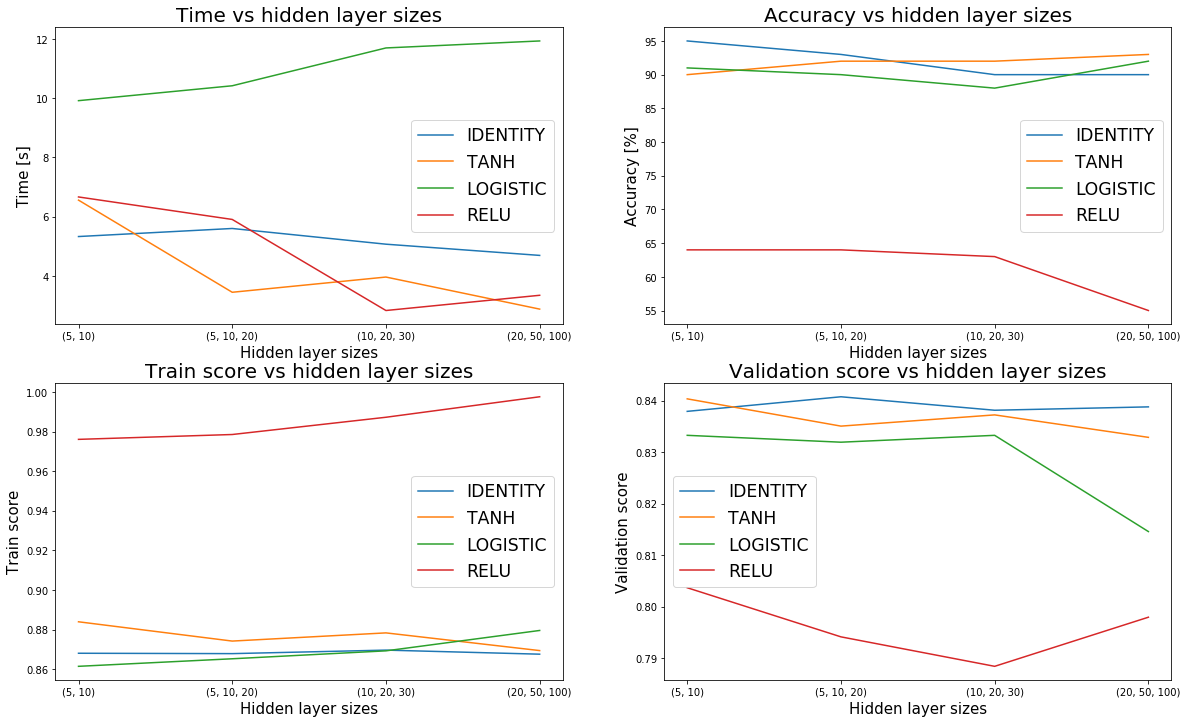

In [247]:
h = [str(h) for h in h_sizes]
fig = plt.figure(figsize = (20,12))

plt.subplot(221)
plt.plot(h, times_dict2[list_fcns[0]], label = list_fcns[0].upper())
plt.plot(h, times_dict2[list_fcns[1]], label = list_fcns[1].upper())
plt.plot(h, times_dict2[list_fcns[2]], label = list_fcns[2].upper())
plt.plot(h, times_dict2[list_fcns[3]], label = list_fcns[3].upper())
plt.legend(fontsize='xx-large')
plt.xlabel('Hidden layer sizes', fontsize = 15)
plt.ylabel('Time [s]', fontsize = 15)
plt.title('Time vs hidden layer sizes', fontsize = 20)

plt.subplot(222)
plt.plot(h, acc_dict2[list_fcns[0]], label = list_fcns[0].upper())
plt.plot(h, acc_dict2[list_fcns[1]], label = list_fcns[1].upper())
plt.plot(h, acc_dict2[list_fcns[2]], label = list_fcns[2].upper())
plt.plot(h, acc_dict2[list_fcns[3]], label = list_fcns[3].upper())
plt.legend(fontsize='xx-large')
plt.xlabel('Hidden layer sizes', fontsize = 15)
plt.ylabel('Accuracy [%]', fontsize = 15)
plt.title('Accuracy vs hidden layer sizes', fontsize = 20)

plt.subplot(223)
plt.plot(h, trainscore_dict2[list_fcns[0]], label = list_fcns[0].upper())
plt.plot(h, trainscore_dict2[list_fcns[1]], label = list_fcns[1].upper())
plt.plot(h, trainscore_dict2[list_fcns[2]], label = list_fcns[2].upper())
plt.plot(h, trainscore_dict2[list_fcns[3]], label = list_fcns[3].upper())
plt.legend(fontsize='xx-large')
plt.xlabel('Hidden layer sizes', fontsize = 15)
plt.ylabel('Train score', fontsize = 15)
plt.title('Train score vs hidden layer sizes', fontsize = 20)

plt.subplot(224)
plt.plot(h, valscore_dict2[list_fcns[0]], label = list_fcns[0].upper())
plt.plot(h, valscore_dict2[list_fcns[1]], label = list_fcns[1].upper())
plt.plot(h, valscore_dict2[list_fcns[2]], label = list_fcns[2].upper())
plt.plot(h, valscore_dict2[list_fcns[3]], label = list_fcns[3].upper())
plt.legend(fontsize='xx-large')
plt.xlabel('Hidden layer sizes', fontsize = 15)
plt.ylabel('Validation score', fontsize = 15)
plt.title('Validation score vs hidden layer sizes', fontsize = 20)
plt.show()


### How much trainig data is needed

In [197]:
X_TRAIN = []  #traininig samples
Y_TRAIN = []  #class labels
x_norm = normalize(fv_train.data, axis = 1)
for i in range(0,fv_train.data.shape[0],1620):
    if(i+1620 <= fv_train.data.shape[0]):
        X_TRAIN.append(x_norm.data[0:(i+1620),:])
        Y_TRAIN.append(fv_train.axes[0][0:(i+1620)]) 
    else:
        X_TRAIN.append(x_norm.data)
        Y_TRAIN.append(fv_train.axes[0])
        
X_TRAIN = np.asarray(X_TRAIN)
Y_TRAIN = np.asarray(Y_TRAIN)

In [225]:
scores = []

for i in range(X_TRAIN.size):
    pred, models = MLP_test(X_TRAIN[i], Y_TRAIN[i], x_test_norm, list_fcns,(50,), valid = True, verbose = False)
    scores.append(models)
    

In [226]:
t = [round(X_TRAIN[i].shape[0]/1620 * 5) for i in range(X_TRAIN.size)]


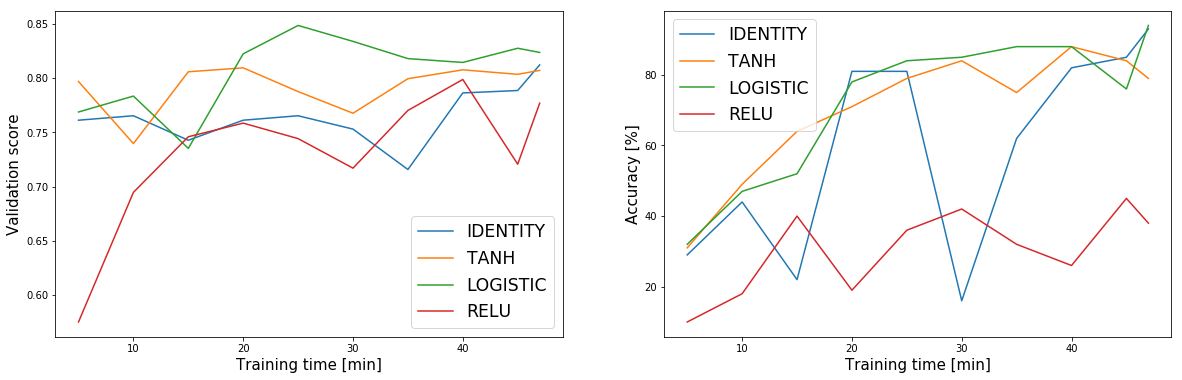

In [227]:
fig = plt.figure(figsize = (20,6))
plt.subplot(122)
plt.plot(t, acc_dict[list_fcns[0]], label = list_fcns[0].upper())
plt.plot(t, acc_dict[list_fcns[1]], label = list_fcns[1].upper())
plt.plot(t, acc_dict[list_fcns[2]], label = list_fcns[2].upper())
plt.plot(t, acc_dict[list_fcns[3]], label = list_fcns[3].upper())
plt.legend(fontsize='xx-large')
plt.xlabel('Training time [min]', fontsize = 15)
plt.ylabel('Accuracy [%]', fontsize = 15)

plt.subplot(121)
plt.plot(t, valscore_dict[list_fcns[0]], label = list_fcns[0].upper())
plt.plot(t, valscore_dict[list_fcns[1]], label = list_fcns[1].upper())
plt.plot(t, valscore_dict[list_fcns[2]], label = list_fcns[2].upper())
plt.plot(t, valscore_dict[list_fcns[3]], label = list_fcns[3].upper())
plt.legend(fontsize='xx-large')
plt.xlabel('Training time [min]', fontsize = 15)
plt.ylabel('Validation score', fontsize = 15)
plt.show()


In [218]:

times_dict = {}
for fcn in list_fcns:
    t = []
    for i in range(len(scores)):
        t.append(scores[i][fcn]['Time [s]'])
    times_dict[fcn] = t
acc_dict = {}
for fcn in list_fcns:
    a = []
    for i in range(len(scores)):
        a.append(scores[i][fcn]['Accuracy [%]'])
    acc_dict[fcn] = a

valscore_dict = {}
for fcn in list_fcns:
    a = []
    for i in range(len(scores)):
        a.append(scores[i][fcn]['Validation score'])
    valscore_dict[fcn] = a

trainscore_dict = {}
for fcn in list_fcns:
    a = []
    for i in range(len(scores)):
        a.append(scores[i][fcn]['Train score'])
    trainscore_dict[fcn] = a  
